## Estimate stock price using Geometric Brownian Motion - s15645

In [52]:
from math import sqrt  
from scipy.stats import norm 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator

In [54]:
stoks_df = pd.read_csv('HASU Historical Data(2).csv')
stoks_df = stoks_df.iloc[:, 0:2]
stoks_df.head()

,Date,Price
0,6/20/2022,32.2
1,6/21/2022,33.0
2,6/22/2022,33.0
3,6/23/2022,33.0
4,6/24/2022,35.0


In [56]:
price = stoks_df.iloc[:, 1]
price.head()

0    32.2
1    33.0
2    33.0
3    33.0
4    35.0
Name: Price, dtype: float64

## a)  Create a time index

In [59]:
stoks_df['time_index'] = range(len(stoks_df))

stoks_df.head()

,Date,Price,time_index
0,6/20/2022,32.2,0
1,6/21/2022,33.0,1
2,6/22/2022,33.0,2
3,6/23/2022,33.0,3
4,6/24/2022,35.0,4


## b) Create logreturn_t

In [62]:
stoks_df['logreturn_t'] = np.log(stoks_df.iloc[:, 1]) - np.log(stoks_df.iloc[:, 1].shift(1))

stoks_df.head()

,Date,Price,time_index,logreturn_t
0,6/20/2022,32.2,0,NaN
1,6/21/2022,33.0,1,0.024541
2,6/22/2022,33.0,2,0.000000
3,6/23/2022,33.0,3,0.000000
4,6/24/2022,35.0,4,0.058841


## c) Estimate drift parameter µ_GB and scale parameter σ 

In [65]:
sample_mean = stoks_df['logreturn_t'].mean()
sample_mean

0.0011909837066137418

In [67]:
sample_var = stoks_df['logreturn_t'].var()
sample_var

0.0005467189389938382

In [69]:
scale_para = sqrt(sample_var)
scale_para

0.023382021704588297

In [71]:
drift_para = sample_mean+ (sample_var/2)
drift_para

0.0014643431761106609

## d) Check the normality

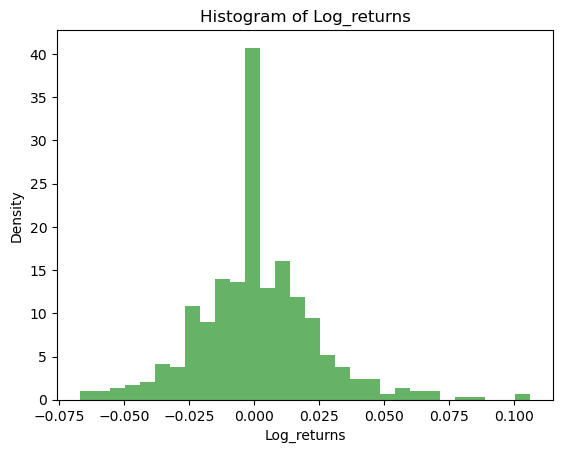

In [74]:
plt.hist(stoks_df['logreturn_t'], bins=30, density=True, alpha=0.6, color='g')


title = "Histogram of Log_returns"

plt.title(title)
plt.xlabel('Log_returns')
plt.ylabel('Density')

plt.show()

## e) Simulate sample paths using Geometric Brownian motion

In [77]:
def Geo_Brownian (m,T,N,sigma,mu,w0,GB=False):
  """
  arguments:
  m- no of sample paths
  T- Total time
  N- no of steps (total no of descritize intervals)
  sigma- Scale parameter
  mu- mean of [ln(x_t)-ln(x_t-1)] = drift-(sigma/2)
  w0- starting value of the stock price

  return:
  numpy array with shape (m,N+1),where the first column gives the initial values of each path
  """
  # length of subinterval
  dt =T/N
  # creating an array to store simulated results
  x = np.zeros((m,N+1))
  # initial values of X
  x[:,0]=w0
  x0= x[:,0]

  if not GB:  ##(to generate standard brownian motion)
    # for each element of x0,generate a sample of n numbers from a normal distraibution
    r = norm.rvs(size=x0.shape + (N,),loc=mu*dt, scale=sigma*sqrt(dt))

    # this computes Brownian motion by taking cumuative sum of random samples
    np.cumsum(r, axis=-1,out=x[:,1:]) ### axis=-1-->column-wise cumulative sum, store them starting from 2nd column as 1st column contain starting values
    
    x[:,1:] +=w0
      
  else:  ###(to generate geometric brownian motion)
    r = norm.rvs(size=x0.shape + (N,),loc=mu*dt, scale=sigma*sqrt(dt))
    np.cumsum(r, axis=-1,out=x[:,1:])
    if w0!=0:
      x[:,1:] = w0*np.exp(x[:,1:])
    else:
      x[:,1:] = np.exp(x[:,1:])
  return x
  

In [79]:
# simulate 5000 sample paths using geometric brownian motion with drift parameter=0.0014643 and scale parameter=0.0233820
sample_paths = Geo_Brownian(5000,20,150,0.0233820,0.001190,58.20,GB=True)
sample_paths.shape

(5000, 151)

## f) Plot sample paths for next 20 days

In [82]:
def Plot_Brownian(y,T):
  """
  arguments:
  y-array with shape(m,N+1).each row gives discritized version of sample path.
  there are m sample paths
  T-total time

  returns:
  a graph of all sample path
  """

  #no of steps
  N = y.shape[1]  
  # length of time step
  dt = T/(N-1)

  t =np.linspace(0.0,N*dt,N)
  for k in range(y.shape[0]): 
    plt.plot(t,y[k])
  plt.xlabel('Time',fontsize=15)
  plt.ylabel('Closing price',fontsize=15)
  plt.title('Sample paths for Closing price of HASU')
  plt.grid(True)
  # Set x-axis to display integers only
  ax = plt.gca()
  ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
  plt.show()

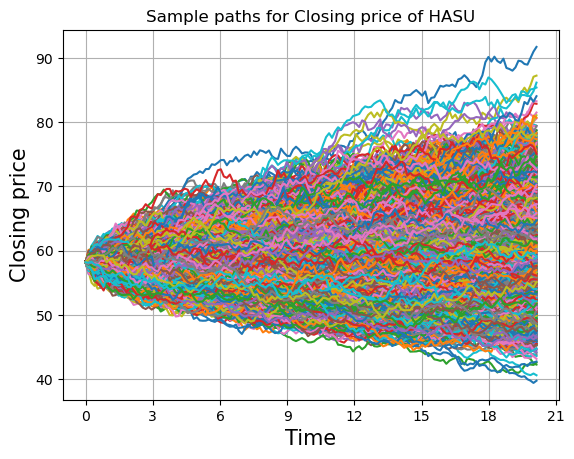

In [84]:
Plot_Brownian(sample_paths,20)

## g) box plot for the possible closing price corresponding to  the last day

In [86]:
def BrownianEnd_boxplot(y,T,loc):
  """
  arguments:
  y-array with shape(m,N+1).each row gives discritized version of sample path.
  there are m sample paths
  T - total time
  loc - location to graph

  return:
  a histogram of values which are obtained by discritizing the sample path at the given location.
  """
  # no of steps
  N = y.shape[1]
  # length of step
  dt = T/(N-1)
  # the position of the array corresponding to the given location
  pos = int(loc/dt)
  # Boxplot
  plt.boxplot(y[:, pos], vert=True)
  plt.xlabel(' last day of the next 20-day period', fontsize=15)
  plt.ylabel('Closing Price', fontsize=15)
  plt.title('Possible closing price corresponding to the last day',fontsize=15)
  plt.grid(True)
  plt.show()


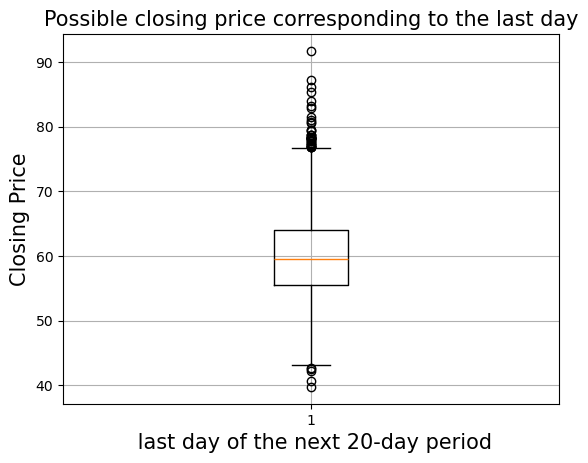

In [87]:
BrownianEnd_boxplot(sample_paths,20,20)

In [88]:
dfGB =pd.DataFrame(sample_paths.T) 
dfGB

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,...,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000,58.200000
1,57.925298,57.837979,59.080739,57.471770,57.615112,58.370519,57.250037,57.589618,59.035381,58.070578,...,57.792754,57.985555,58.142247,58.623340,57.987137,58.089574,58.155210,58.500469,58.634009,58.112194
2,58.237104,57.250681,60.354498,57.232747,57.120774,58.229360,56.277228,56.929736,58.230620,58.242921,...,58.133928,57.748235,57.655655,58.736697,58.191570,58.557139,59.091021,58.510969,59.195171,58.270752
3,58.100403,56.260256,60.940073,56.715699,56.976091,57.753166,55.838151,57.327934,58.856959,57.472931,...,58.708392,57.856654,57.417207,58.077778,57.824344,59.060006,58.309639,58.409356,59.190939,57.840718
4,58.654957,56.649612,61.339510,56.163179,56.706738,58.073597,55.362188,58.019080,59.404014,56.992018,...,59.339659,57.591281,57.706434,58.477746,57.563195,58.833195,57.998367,58.227472,59.313547,57.833735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,56.209101,62.982453,66.310754,62.182606,51.576658,53.408964,48.601745,59.577145,56.066892,61.914168,...,64.118449,56.042877,52.250420,55.188059,57.965732,55.553362,65.303461,50.195878,54.076817,59.123547
147,57.322584,62.620726,65.585512,60.836013,51.534173,53.156452,49.022530,59.967746,55.627492,61.719262,...,64.123481,56.462300,52.043642,55.456263,57.947031,56.363223,65.348831,49.895701,54.988492,59.805481
148,57.672083,62.432076,65.802096,60.233989,51.817146,53.293867,49.188680,59.891956,55.717490,61.513449,...,64.005885,57.223450,51.530186,56.488345,58.617593,56.218760,65.334271,49.707472,54.707968,59.503673
149,57.515306,62.654247,66.773399,60.456097,51.147297,53.306392,48.700273,59.301253,56.116488,61.429155,...,64.084075,56.688897,51.137156,56.271141,58.465630,57.399476,65.126642,49.166021,54.309351,59.560231


In [89]:
ending_GB = dfGB.loc[150]
ending_GB.describe()

count    5000.000000
mean       59.978634
std         6.233993
min        39.761341
25%        55.595279
50%        59.617906
75%        64.061380
max        91.723334
Name: 150, dtype: float64

## h)Probability that the closing price last dayd is between 55 and 60

In [91]:
# probability of stock price at t=20 is in between 55 and 60
len(ending_GB[(ending_GB>55) & (ending_GB<60)]) / len(ending_GB)


0.308

## i) 95% prediction interval for ending values

In [93]:
# 95% prediction interval for ending values
np.percentile(ending_GB,[2.5,97.5])

array([48.96786403, 72.94923527])

In [94]:
## ST4031
## Index: s15645